# BERT Step by Step: Self-Attention

In the context of deep learning, attention is a mechanism that enables a model to focus on specific parts of input data while processing information. It allows the model to assign varying degrees of importance or relevance to different elements of the input, rather than treating all elements uniformly.

Attention mechanisms have been widely employed in natural language processing tasks, such as machine translation, text summarization, and sentiment analysis, as well as in computer vision applications, allowing models to selectively attend to relevant regions of an image or sequence. The concept is inspired by human cognitive processes that involve selectively focusing on specific information to better comprehend and process complex data.

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import AutoConfig, AutoTokenizer
from transformers import BertForPreTraining

import utils
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_checkpoint = 'bert-base-uncased'

model = BertForPreTraining.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
config = AutoConfig.from_pretrained(model_checkpoint)

In [3]:
encoding = tokenizer.encode("let's tokenize something as an example for this notebook?",
                            return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(encoding.flatten())
seq_embedding = model.bert.embeddings.word_embeddings(encoding)
seq_embedding.shape   # (batch_size, seq_len, hidden_size)

torch.Size([1, 15, 768])

### Cosine similarity

In [4]:
scores_cos = F.cosine_similarity(seq_embedding[0].unsqueeze(1), seq_embedding, dim=2)

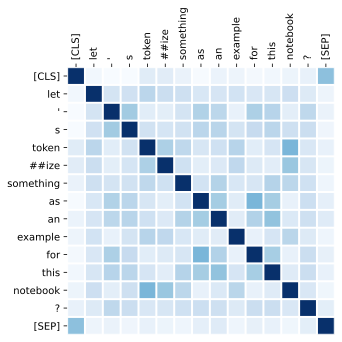

In [5]:
utils.plot_matrix(scores_cos.detach().numpy(), tokens)

### Simple Attention

In [6]:
# batch matrix multiplication
# gives all the dot products between the embeddings in the sequence
scores = torch.bmm(seq_embedding, seq_embedding.transpose(1, 2))

weights = F.softmax(scores, dim=-1)

# Weighted average
seq_embedding_att = torch.bmm(weights, seq_embedding)
seq_embedding_att.shape

torch.Size([1, 15, 768])

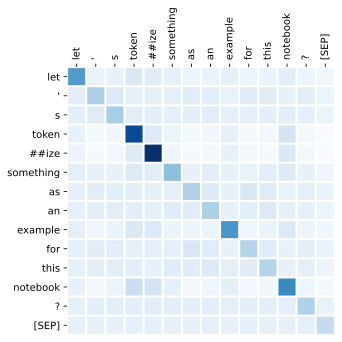

In [7]:
# we are using [1:, 1:] to take the `[CLS]` and `[SEP]` tokens out of the plot
utils.plot_matrix(weights.detach().numpy()[0][1:, 1:], tokens[1:])

### Scaled dot product attention

> from Natural Language Processing with Transformers, Revised Edition

The basic attention mechanism above will assign a very large score to identical words in the context, and in particular to the current word itself: the dot product of a query with itself is 1. But in practice, the meaning of a word will be better informed by complementary words in the context than by identical words—for example, the meaning of “flies” is better defined by incorporating information from “time” and “arrow” than by another mention of “flies”.
Let’s allow the model to create a different set of vectors for the query, key, and value of a token by using three different linear projections to project our initial token vector into three different spaces.

$$
Q = W^{\text{q}}E
$$
$$
K = W^{\text{k}}E
$$
$$
V = W^{\text{v}}E
$$

Now the first matrix multiplication $EE^{\text{T}}$ that we did to get the similarities becomes $EQ^{\text{T}}$:
$$
\color{black} QK^{\text{T}}
$$
Then that's normalized by the square root of the size of the matrix $d_k$ and a softmax function is applied to it.
Now the attention coefficients are
$$
a_{ij} = \text{softmax} \left( \frac{Q K^{\text{T}}}{\sqrt{d_k}} \right)_{ij}
% a = \text{softmax} \left( \frac{\mathbf{q} \cdot \mathbf{k}}{\sqrt{d_k}} \right)
$$

In the scaled dot product attention, the $a_{ij}$ are normalized with a softmax to ensure all the columns or rows sum to 1.

$$
\text{seq}^* \equiv \text{E}^*_{ij} = \sum_k^{\mathrm{hid\ size}} a_{ik}v_{kj}
$$

We often see the whole thing written in one step as
$$
\text{E}^* = \text{softmax} \left( \frac{Q K^{\text{T}}}{\sqrt{d_k}} \right)V
$$

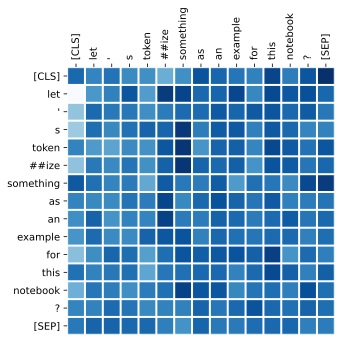

In [8]:
head_dim = config.hidden_size // config.num_attention_heads

query = nn.Linear(config.hidden_size, 64, bias=False)(seq_embedding)  # Q = W_qE
key   = nn.Linear(config.hidden_size, 64, bias=False)(seq_embedding)  # K = W_kE
value = nn.Linear(config.hidden_size, 64, bias=False)(seq_embedding)  # V = W_vE

dim_k = query.shape[-1]

scores = torch.bmm(query, key.transpose(1, 2)) / torch.math.sqrt(dim_k)  # QK^T / sqrt(dim_k)

weights = F.softmax(scores, dim=-1)  # softmax(QK^T / sqrt(dim_k))

seq_embedding_att = torch.bmm(weights, value)   # softmax(QK^T / sqrt(dim_k))V


utils.plot_matrix(weights.detach().numpy()[0], tokens)

In [9]:
def scaled_dot_product_attention(seq_embedding):
    head_dim = config.hidden_size // config.num_attention_heads
    query = nn.Linear(config.hidden_size, head_dim)(seq_embedding)
    key = nn.Linear(config.hidden_size, head_dim)(seq_embedding)
    value = nn.Linear(config.hidden_size, head_dim)(seq_embedding)
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / torch.math.sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)

In [10]:
att_concat = torch.cat([scaled_dot_product_attention(seq_embedding)
                        for i in range(config.num_attention_heads)], dim=-1)

In [11]:
att_concat.shape

torch.Size([1, 15, 768])